<a href="https://colab.research.google.com/github/kaioribeiro97/Mapa_Da_Eleicoes_2022/blob/main/Elei%C3%A7%C3%B5es_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Obtendo os dados

In [1]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install geobr


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Importando pacotes necessários
import os
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import geobr
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

Os dados são baixos no portal de dados abertos do TSE: https://dadosabertos.tse.jus.br/

Para este projeto foi utilizado os seguintes dados: https://dadosabertos.tse.jus.br/dataset/resultados-2022/resource/f509562b-3b7f-487d-ad61-145a7ae6b96f

Estes arquivos contem dados dos resultados de todas as UFs incluindo a ZZ(exterior) com a totalização para o cargo de Presidente. O arquivo é do tipo csv, e possui 1.5Gb, por ser muito pesado, foi necessário transformar em arquivo .parquet, reduzindo em 83% o tamanho do arquivo.

In [5]:
#Foi necessario transformar o arquivo csv para parquet para que diminua o tamanho do arquivo
# df2 = pd.read_csv('drive/MyDrive/projeto_eleições/votacao_secao_2022_BR.csv')
# df2.to_parquet('drive/MyDrive/projeto_eleições/votacao_secao_2022_BR.parquet')

In [6]:
# a redução do tamanho do arquivo foi de 83%
df2=pd.read_parquet('drive/MyDrive/projeto_eleições/votacao_secao_2022_BR.parquet')

# 2. Separando os dados por turno

In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5380736 entries, 0 to 5380735
Data columns (total 26 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   DT_GERACAO                 object
 1   HH_GERACAO                 object
 2   ANO_ELEICAO                int64 
 3   CD_TIPO_ELEICAO            int64 
 4   NM_TIPO_ELEICAO            object
 5   NR_TURNO                   int64 
 6   CD_ELEICAO                 int64 
 7   DS_ELEICAO                 object
 8   DT_ELEICAO                 object
 9   TP_ABRANGENCIA             object
 10  SG_UF                      object
 11  SG_UE                      object
 12  NM_UE                      object
 13  CD_MUNICIPIO               int64 
 14  NM_MUNICIPIO               object
 15  NR_ZONA                    int64 
 16  NR_SECAO                   int64 
 17  CD_CARGO                   int64 
 18  DS_CARGO                   object
 19  NR_VOTAVEL                 int64 
 20  NM_VOTAVEL              

In [8]:
df2.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,...,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
0,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,157,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1015,280001607829,CENTRO ADMINISTRATIVO FABIANO MELO (ANTIGA FAC...,"AV. GOIÁS, 556"
1,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,500,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,173,2526,280001607829,UNIÃO GAÚCHA J. SIMÕES LOPES NETO,"AV. ENGENHEIRO ILDEFONSO SIMÕES LOPES, 531"
2,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,221,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,129,1180,280001607829,UTRAMIG,"AVENIDA AFONSO PENA, 3400"
3,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,92,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1023,280001607829,ESCOLA ESTADUAL GUIMARAES ROSA,"RUA ELIEZER PENA, 177"
4,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,300,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,141,1139,280001607829,COLÉGIO ESTADUAL RUBENS FARRULA,"AV. PLACIDO FIGUEIREDO JUNIOR, S/N"


In [9]:
# df2['NR_VOTAVEL'] =df2['NR_VOTAVEL'].astype(str)

In [10]:
df_2022_1turno_por_estado =df2.query('NR_TURNO == 1 & SG_UF != "ZZ"') #Separa o arquivo, obtendo apenas os votos do 1º turno e votos realizados no Brasil.
df_2022_2turno_por_estado =df2.query('NR_TURNO == 2 & SG_UF != "ZZ"') #Separa o arquivo, obtendo apenas os votos do 2º turno e votos realizados no Brasil.
df_2022_1turno_vts_validos = df2.query('NR_TURNO == 1 & NR_VOTAVEL != 96 & NR_VOTAVEL != 95 & NR_VOTAVEL != 97') #separa os arquivos do 1º turno, obtendo apenas os votos de cada candidado.
df_2022_2turno_vts_validos = df2.query('NR_TURNO == 2 & NR_VOTAVEL != 96 & NR_VOTAVEL != 95 & NR_VOTAVEL != 97') #separa os arquivos do 2º turno, obtendo apenas os votos de cada candidado.


In [11]:
#variáveis globais
LOCAL = 'BRASIL' # Recebe a sigla da UF ou BRASIL
TIPO_CANDIDATO = 'PRESIDENTE' # Recebe o CARGO

#3. Primeiro Turno

Agrupando os votos com os cadidatos mais votado por municipio e o candidato mais votado por estado nos dois turnos (2022)

In [12]:
#obtemos o candidato mais votado em cada municipio no 1º turno
candidatos_mais_votados_2022 = df_2022_1turno_por_estado[df_2022_1turno_por_estado['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','CD_MUNICIPIO'])\
.agg({'NM_VOTAVEL' :'first', 'CD_MUNICIPIO' :'first', 
      'NR_VOTAVEL' :'first','NM_MUNICIPIO':'first',  'SG_UF':'first','NR_TURNO':'first','DS_CARGO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['CD_MUNICIPIO'],keep='first')

#obtemos o candidato mais votado em cada UF no 1º turno
candidatos_mais_votados_2022_1turno_UF = df_2022_1turno_por_estado[df_2022_1turno_por_estado['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','SG_UF'])\
.agg({'NM_VOTAVEL' :'first', 
      'NR_VOTAVEL' :'first', 'SG_UF':'first','NR_TURNO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['SG_UF'],keep='first')

# Votos Totais de cada candidatos
candidatos_votados_2022_1turno = df_2022_1turno_vts_validos[df_2022_1turno_vts_validos['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','NM_VOTAVEL'])\
.agg({'NR_VOTAVEL' :'first','NR_TURNO':'first','NM_VOTAVEL':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)




In [13]:
candidatos_votados_2022_1turno

,,NR_VOTAVEL,NR_TURNO,NM_VOTAVEL,QT_VOTOS
NR_VOTAVEL,NM_VOTAVEL,,,,
13,LUIZ INÁCIO LULA DA SILVA,13,1,LUIZ INÁCIO LULA DA SILVA,57259504
22,JAIR MESSIAS BOLSONARO,22,1,JAIR MESSIAS BOLSONARO,51072345
15,SIMONE NASSAR TEBET,15,1,SIMONE NASSAR TEBET,4915423
12,CIRO FERREIRA GOMES,12,1,CIRO FERREIRA GOMES,3599287
44,SORAYA VIEIRA THRONICKE,44,1,SORAYA VIEIRA THRONICKE,600955
30,LUIZ FELIPE CHAVES D AVILA,30,1,LUIZ FELIPE CHAVES D AVILA,559708
14,KELMON LUIS DA SILVA SOUZA,14,1,KELMON LUIS DA SILVA SOUZA,81129
80,LEONARDO PÉRICLES VIEIRA ROQUE,80,1,LEONARDO PÉRICLES VIEIRA ROQUE,53519
21,SOFIA PADUA MANZANO,21,1,SOFIA PADUA MANZANO,45620


In [14]:
# Plotando os votos de cada candidato
import plotly.express as px
fig = px.pie(candidatos_votados_2022_1turno, values=candidatos_votados_2022_1turno['QT_VOTOS'], names=candidatos_votados_2022_1turno['NM_VOTAVEL'], title='Porcetagem de cada candidato')
fig.show()

Podemos reparar que o candidato Luiz Inácio Lula da Silva foi o candidato mais votados, pórem é necessário um segundo turno pois não obteve a maioria dos votos, com isso, o candidato irá disputar um segundo turno com o candidato Jair Messias Bolsonaro.

----------------
#### As cidades que mais apoiaram Lula e Bolsonaro no primeiro turno das eleições 2022

In [15]:
# obtendo o total de votos que foi realizado em cada municipio(BR)
total_votos_por_municipio = df_2022_1turno_vts_validos[df_2022_1turno_vts_validos['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['SG_UF','NM_MUNICIPIO'])\
.agg({'CD_MUNICIPIO' :'first', 
      'NM_MUNICIPIO':'first',  'SG_UF':'first','NR_TURNO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['CD_MUNICIPIO'],keep='first')

total_votos_por_municipio.reset_index(drop = True, inplace = True)
total_votos_por_municipio= total_votos_por_municipio.query('SG_UF != "ZZ"')

In [16]:
total_votos_por_municipio

,CD_MUNICIPIO,NM_MUNICIPIO,SG_UF,NR_TURNO,QT_VOTOS
0,71072,SÃO PAULO,SP,1,6892638
1,60011,RIO DE JANEIRO,RJ,1,3608284
2,97012,BRASÍLIA,DF,1,1762575
3,38490,SALVADOR,BA,1,1526709
4,13897,FORTALEZA,CE,1,1507639
...,...,...,...,...,...
5614,43117,CEDRO DO ABAETÉ,MG,1,894
5615,53317,SERRA DA SAUDADE,MG,1,889
5616,92231,ANHANGÜERA,GO,1,879
5618,90239,ARAGUAINHA,MT,1,814


In [17]:
total_votos_por_municipio = total_votos_por_municipio.rename(columns={"QT_VOTOS": "TOTAL_VOTOS"})
total_votos_por_municipio

,CD_MUNICIPIO,NM_MUNICIPIO,SG_UF,NR_TURNO,TOTAL_VOTOS
0,71072,SÃO PAULO,SP,1,6892638
1,60011,RIO DE JANEIRO,RJ,1,3608284
2,97012,BRASÍLIA,DF,1,1762575
3,38490,SALVADOR,BA,1,1526709
4,13897,FORTALEZA,CE,1,1507639
...,...,...,...,...,...
5614,43117,CEDRO DO ABAETÉ,MG,1,894
5615,53317,SERRA DA SAUDADE,MG,1,889
5616,92231,ANHANGÜERA,GO,1,879
5618,90239,ARAGUAINHA,MT,1,814


In [18]:
candidatos_mais_votados_2022.reset_index(drop = True, inplace = True)

In [19]:
candidatos_mais_votados_2022

,NM_VOTAVEL,CD_MUNICIPIO,NR_VOTAVEL,NM_MUNICIPIO,SG_UF,NR_TURNO,DS_CARGO,QT_VOTOS
0,LUIZ INÁCIO LULA DA SILVA,71072,13,SÃO PAULO,SP,1,PRESIDENTE,3276512
1,JAIR MESSIAS BOLSONARO,60011,22,RIO DE JANEIRO,RJ,1,PRESIDENTE,1695777
2,LUIZ INÁCIO LULA DA SILVA,38490,13,SALVADOR,BA,1,PRESIDENTE,1022728
3,JAIR MESSIAS BOLSONARO,97012,22,BRASÍLIA,DF,1,PRESIDENTE,910397
4,LUIZ INÁCIO LULA DA SILVA,13897,13,FORTALEZA,CE,1,PRESIDENTE,802009
...,...,...,...,...,...,...,...,...
5565,LUIZ INÁCIO LULA DA SILVA,90239,13,ARAGUAINHA,MT,1,PRESIDENTE,465
5566,JAIR MESSIAS BOLSONARO,62430,22,BORÁ,SP,1,PRESIDENTE,444
5567,LUIZ INÁCIO LULA DA SILVA,43117,13,CEDRO DO ABAETÉ,MG,1,PRESIDENTE,432
5568,LUIZ INÁCIO LULA DA SILVA,92231,13,ANHANGÜERA,GO,1,PRESIDENTE,428


In [20]:
# realizo um merge entre a tabela de votos totais do municipio e o candidato mais votado neste municipio, assim obtemos a porcetagem de cada canditado neste municipio, e conseguimos visualizar quais as maiores diferenças de votos entre os candidatos
Porcetagem_de_cada_candidato_no_municipio = pd.merge(candidatos_mais_votados_2022, total_votos_por_municipio, how = 'right', on = ['NM_MUNICIPIO','CD_MUNICIPIO'])
Porcetagem_de_cada_candidato_no_municipio = Porcetagem_de_cada_candidato_no_municipio.drop(['NR_TURNO_x', 'SG_UF_x'], axis=1)
Porcetagem_de_cada_candidato_no_municipio = Porcetagem_de_cada_candidato_no_municipio.rename(columns={"SG_UF_y": "SG_UF","NR_TURNO_y":"NR_TURNO"})
Porcetagem_de_cada_candidato_no_municipio['PORCETAGEM'] = (Porcetagem_de_cada_candidato_no_municipio['QT_VOTOS']*100)/Porcetagem_de_cada_candidato_no_municipio['TOTAL_VOTOS']


In [21]:
Porcetagem_de_cada_candidato_no_municipio

,NM_VOTAVEL,CD_MUNICIPIO,NR_VOTAVEL,NM_MUNICIPIO,DS_CARGO,QT_VOTOS,SG_UF,NR_TURNO,TOTAL_VOTOS,PORCETAGEM
0,LUIZ INÁCIO LULA DA SILVA,71072,13,SÃO PAULO,PRESIDENTE,3276512,SP,1,6892638,47.536400
1,JAIR MESSIAS BOLSONARO,60011,22,RIO DE JANEIRO,PRESIDENTE,1695777,RJ,1,3608284,46.996772
2,JAIR MESSIAS BOLSONARO,97012,22,BRASÍLIA,PRESIDENTE,910397,DF,1,1762575,51.651533
3,LUIZ INÁCIO LULA DA SILVA,38490,13,SALVADOR,PRESIDENTE,1022728,BA,1,1526709,66.989059
4,LUIZ INÁCIO LULA DA SILVA,13897,13,FORTALEZA,PRESIDENTE,802009,CE,1,1507639,53.196355
...,...,...,...,...,...,...,...,...,...,...
5565,LUIZ INÁCIO LULA DA SILVA,43117,13,CEDRO DO ABAETÉ,PRESIDENTE,432,MG,1,894,48.322148
5566,JAIR MESSIAS BOLSONARO,53317,22,SERRA DA SAUDADE,PRESIDENTE,419,MG,1,889,47.131609
5567,LUIZ INÁCIO LULA DA SILVA,92231,13,ANHANGÜERA,PRESIDENTE,428,GO,1,879,48.691695
5568,LUIZ INÁCIO LULA DA SILVA,90239,13,ARAGUAINHA,PRESIDENTE,465,MT,1,814,57.125307


In [22]:
maiores_porcetagem_lula = Porcetagem_de_cada_candidato_no_municipio.query('NR_VOTAVEL == 13')
maiores_porcetagem_bolsonaro = Porcetagem_de_cada_candidato_no_municipio.query('NR_VOTAVEL == 22')

In [23]:
maiores_porcetagem_lula = maiores_porcetagem_lula.nlargest(5, 'PORCETAGEM')
maiores_porcetagem_bolsonaro =maiores_porcetagem_bolsonaro.nlargest(5, 'PORCETAGEM')

In [24]:
maiores_diferença = pd.concat([maiores_porcetagem_lula, maiores_porcetagem_bolsonaro])
maiores_diferença["Municipio_UF"] = maiores_diferença["NM_MUNICIPIO"] + "/" + maiores_diferença["SG_UF"]


In [25]:
# 5 maiores diferenças de votos para cada um dos 2 candidatos mais votados
maiores_diferença

,NM_VOTAVEL,CD_MUNICIPIO,NR_VOTAVEL,NM_MUNICIPIO,DS_CARGO,QT_VOTOS,SG_UF,NR_TURNO,TOTAL_VOTOS,PORCETAGEM,Municipio_UF
4396,LUIZ INÁCIO LULA DA SILVA,10804,13,GUARIBAS,PRESIDENTE,2966,PI,1,3219,92.140416,GUARIBAS/PI
4159,LUIZ INÁCIO LULA DA SILVA,10260,13,FARTURA DO PIAUÍ,PRESIDENTE,3310,PI,1,3620,91.436464,FARTURA DO PIAUÍ/PI
2294,LUIZ INÁCIO LULA DA SILVA,23167,13,CARNAUBEIRA DA PENHA,PRESIDENTE,7994,PE,1,8760,91.255708,CARNAUBEIRA DA PENHA/PE
3952,LUIZ INÁCIO LULA DA SILVA,10413,13,CAMPINAS DO PIAUÍ,PRESIDENTE,3635,PI,1,3998,90.920460,CAMPINAS DO PIAUÍ/PI
4529,LUIZ INÁCIO LULA DA SILVA,10707,13,CAPITÃO GERVÁSIO OLIVEIRA,PRESIDENTE,2730,PI,1,3014,90.577306,CAPITÃO GERVÁSIO OLIVEIRA/PI
5233,JAIR MESSIAS BOLSONARO,87220,22,NOVA PÁDUA,PRESIDENTE,1672,RS,1,1991,83.977901,NOVA PÁDUA/RS
3091,JAIR MESSIAS BOLSONARO,79790,22,NOVA SANTA ROSA,PRESIDENTE,4804,PR,1,5844,82.203970,NOVA SANTA ROSA/PR
4400,JAIR MESSIAS BOLSONARO,74683,22,QUATRO PONTES,PRESIDENTE,2584,PR,1,3217,80.323283,QUATRO PONTES/PR
1208,JAIR MESSIAS BOLSONARO,4383,22,NOVO PROGRESSO,PRESIDENTE,12824,PA,1,16111,79.597790,NOVO PROGRESSO/PA
3932,JAIR MESSIAS BOLSONARO,74560,22,MERCEDES,PRESIDENTE,3174,PR,1,4029,78.778853,MERCEDES/PR


In [26]:
fig = px.bar(maiores_diferença, x='Municipio_UF', y='PORCETAGEM',color="NM_VOTAVEL",title="As cidades mais lulistas e mais bolsonaristas")
fig.show()

Piauí e Pernambuco são os estados com alguns dos municípios mais lulistas do primeiro turno das eleições 2022. No apoio bolsonarista, os estados com maior índice de votação estão no Sul.

#4. Segundo Turno


O segundo turno foi realizado entre os candidatos Luiz Inácio Lula da Silva (PT) e Jair Messias Bolsonaro (PL)

In [27]:
#obtemos o candidato mais votado em cada municipio no 1º turno
candidatos_mais_votados_2022_2_turno = df_2022_2turno_por_estado[df_2022_2turno_por_estado['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','CD_MUNICIPIO'])\
.agg({'NM_VOTAVEL' :'first', 'CD_MUNICIPIO' :'first', 
      'NR_VOTAVEL' :'first','NM_MUNICIPIO':'first',  'SG_UF':'first','NR_TURNO':'first','DS_CARGO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['CD_MUNICIPIO'],keep='first')
      
#obtemos o candidato mais votado em cada UF no 1º turno
candidatos_mais_votados_2022_2turno_UF = df_2022_2turno_por_estado[df_2022_2turno_por_estado['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','SG_UF'])\
.agg({'NM_VOTAVEL' :'first', 
      'NR_VOTAVEL' :'first', 'SG_UF':'first','NR_TURNO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['SG_UF'],keep='first')

# Votos Totais de cada candidatos
candidatos_votados_2022_2turno = df_2022_2turno_vts_validos[df_2022_2turno_vts_validos['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','NM_VOTAVEL'])\
.agg({'NR_VOTAVEL' :'first','NR_TURNO':'first','NM_VOTAVEL':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)




In [28]:
candidatos_votados_2022_2turno

,,NR_VOTAVEL,NR_TURNO,NM_VOTAVEL,QT_VOTOS
NR_VOTAVEL,NM_VOTAVEL,,,,
13,LUIZ INÁCIO LULA DA SILVA,13,2,LUIZ INÁCIO LULA DA SILVA,60345999
22,JAIR MESSIAS BOLSONARO,22,2,JAIR MESSIAS BOLSONARO,58206354


In [29]:
# Plotando os votos de cada candidato
import plotly.express as px
fig = px.pie(candidatos_votados_2022_2turno, values=candidatos_votados_2022_2turno['QT_VOTOS'], names=candidatos_votados_2022_2turno['NM_VOTAVEL'], title='Porcetagem de cada candidato')
fig.show()

Podemos reparar que o candidato Luiz Inácio Lula da Silva foi o candidato mais votados, com isso foi o candidato eleito para o cargo de Presidente do Brasil.

##### As cidades que mais apoiam cada candidato

In [30]:
# obtendo o total de votos que foi realizado em cada municipio(BR)
total_votos_por_municipio_2_turno = df_2022_2turno_vts_validos[df_2022_2turno_vts_validos['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['SG_UF','NM_MUNICIPIO'])\
.agg({'CD_MUNICIPIO' :'first', 
      'NM_MUNICIPIO':'first',  'SG_UF':'first','NR_TURNO':'last',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['CD_MUNICIPIO'],keep='first')

total_votos_por_municipio_2_turno.reset_index(drop = True, inplace = True)
total_votos_por_municipio_2_turno =total_votos_por_municipio_2_turno.query('SG_UF != "ZZ"')
total_votos_por_municipio_2_turno = total_votos_por_municipio_2_turno.rename(columns={"QT_VOTOS": "TOTAL_VOTOS"})

In [31]:
total_votos_por_municipio_2_turno

,CD_MUNICIPIO,NM_MUNICIPIO,SG_UF,NR_TURNO,TOTAL_VOTOS
0,71072,SÃO PAULO,SP,2,6869405
1,60011,RIO DE JANEIRO,RJ,2,3663368
2,97012,BRASÍLIA,DF,2,1770626
3,38490,SALVADOR,BA,2,1541030
4,41238,BELO HORIZONTE,MG,2,1538303
...,...,...,...,...,...
5614,43117,CEDRO DO ABAETÉ,MG,2,890
5615,92231,ANHANGÜERA,GO,2,854
5617,53317,SERRA DA SAUDADE,MG,2,819
5618,62430,BORÁ,SP,2,790


In [32]:
total_votos_por_municipio_2_turno['NR_TURNO'].unique()

array([2])

In [33]:
candidatos_mais_votados_2022_2_turno.reset_index(drop = True, inplace = True)
Porcetagem_de_cada_candidato_no_municipio_2Turno = pd.merge(candidatos_mais_votados_2022_2_turno, total_votos_por_municipio_2_turno, how = 'right', on = ['NM_MUNICIPIO','CD_MUNICIPIO'])
Porcetagem_de_cada_candidato_no_municipio_2Turno = Porcetagem_de_cada_candidato_no_municipio_2Turno.drop(['NR_TURNO_x', 'SG_UF_x'], axis=1)
Porcetagem_de_cada_candidato_no_municipio_2Turno = Porcetagem_de_cada_candidato_no_municipio_2Turno.rename(columns={"SG_UF_y": "SG_UF","NR_TURNO_y":"NR_TURNO"})
Porcetagem_de_cada_candidato_no_municipio_2Turno['PORCETAGEM'] = (Porcetagem_de_cada_candidato_no_municipio_2Turno['QT_VOTOS']*100)/Porcetagem_de_cada_candidato_no_municipio_2Turno['TOTAL_VOTOS']


In [34]:
Porcetagem_de_cada_candidato_no_municipio_2Turno.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5570 entries, 0 to 5569
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NM_VOTAVEL    5570 non-null   object 
 1   CD_MUNICIPIO  5570 non-null   int64  
 2   NR_VOTAVEL    5570 non-null   int64  
 3   NM_MUNICIPIO  5570 non-null   object 
 4   DS_CARGO      5570 non-null   object 
 5   QT_VOTOS      5570 non-null   int64  
 6   SG_UF         5570 non-null   object 
 7   NR_TURNO      5570 non-null   int64  
 8   TOTAL_VOTOS   5570 non-null   int64  
 9   PORCETAGEM    5570 non-null   float64
dtypes: float64(1), int64(5), object(4)
memory usage: 478.7+ KB


In [35]:
maiores_porcetagem_lula_2_turno = Porcetagem_de_cada_candidato_no_municipio_2Turno.query('NR_VOTAVEL == 13')
maiores_porcetagem_bolsonaro_2_turno = Porcetagem_de_cada_candidato_no_municipio_2Turno.query('NR_VOTAVEL == 22')
maiores_porcetagem_lula_2_turno = maiores_porcetagem_lula_2_turno.nlargest(5, 'PORCETAGEM')
maiores_porcetagem_bolsonaro_2_turno =maiores_porcetagem_bolsonaro_2_turno.nlargest(5, 'PORCETAGEM')
maiores_diferença_2_turno = pd.concat([maiores_porcetagem_lula_2_turno, maiores_porcetagem_bolsonaro_2_turno])

maiores_diferença_2_turno["Municipio_UF"] = maiores_diferença_2_turno["NM_MUNICIPIO"] + "/" + maiores_diferença_2_turno["SG_UF"]

In [36]:
maiores_diferença_2_turno

,NM_VOTAVEL,CD_MUNICIPIO,NR_VOTAVEL,NM_MUNICIPIO,DS_CARGO,QT_VOTOS,SG_UF,NR_TURNO,TOTAL_VOTOS,PORCETAGEM,Municipio_UF
4453,LUIZ INÁCIO LULA DA SILVA,10804,13,GUARIBAS,PRESIDENTE,2949,PI,2,3142,93.857416,GUARIBAS/PI
3982,LUIZ INÁCIO LULA DA SILVA,10413,13,CAMPINAS DO PIAUÍ,PRESIDENTE,3674,PI,2,3946,93.106944,CAMPINAS DO PIAUÍ/PI
4028,LUIZ INÁCIO LULA DA SILVA,10081,13,BONFIM DO PIAUÍ,PRESIDENTE,3582,PI,2,3869,92.582063,BONFIM DO PIAUÍ/PI
4196,LUIZ INÁCIO LULA DA SILVA,10260,13,FARTURA DO PIAUÍ,PRESIDENTE,3266,PI,2,3530,92.521246,FARTURA DO PIAUÍ/PI
4548,LUIZ INÁCIO LULA DA SILVA,10707,13,CAPITÃO GERVÁSIO OLIVEIRA,PRESIDENTE,2765,PI,2,2991,92.443999,CAPITÃO GERVÁSIO OLIVEIRA/PI
5199,JAIR MESSIAS BOLSONARO,87220,22,NOVA PÁDUA,PRESIDENTE,1819,RS,2,2044,88.992172,NOVA PÁDUA/RS
3067,JAIR MESSIAS BOLSONARO,79790,22,NOVA SANTA ROSA,PRESIDENTE,5062,PR,2,5905,85.723963,NOVA SANTA ROSA/PR
4359,JAIR MESSIAS BOLSONARO,74683,22,QUATRO PONTES,PRESIDENTE,2790,PR,2,3274,85.216860,QUATRO PONTES/PR
4033,JAIR MESSIAS BOLSONARO,82937,22,RIO FORTUNA,PRESIDENTE,3280,SC,2,3864,84.886128,RIO FORTUNA/SC
2991,JAIR MESSIAS BOLSONARO,87610,22,NOVA BASSANO,PRESIDENTE,5151,RS,2,6144,83.837891,NOVA BASSANO/RS


In [37]:
fig = px.bar(maiores_diferença_2_turno, x='Municipio_UF', y='PORCETAGEM',color="NM_VOTAVEL",title="As cidades mais lulistas e mais bolsonaristas")
fig.show()

No 2º turno o candidato Lula teve as 5 maiores diferenças presente apenas no estado do Piaui. O candidato bolsonaro manteve a sua hegemonia nas cidades do sul do pais, porem conseguiu abrir uma vantagem em uma cidade do estado de Santa Catarina

-----------

#5. Preparando os dados de localização


In [38]:
#alterando formato de exibição dos gráficos do Pandas
pd.options.plotting.backend = 'plotly'


In [39]:
geobr.list_geobr()

Function: read_country
Geographies available: Country
Years available: 1872, 1900, 1911, 1920, 1933, 1940, 1950, 1960, 1970, 1980, 1991, 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_region
Geographies available: Region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_state
Geographies available: States
Years available: 1872, 1900, 1911, 1920, 1933, 1940, 1950, 1960, 1970, 1980, 1991, 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_meso_region
Geographies available: Meso region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020
Source: IBGE
------------------------------
Function: read_micro_region
Geographies available: Micro region
Years available: 2000, 2001, 2010, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020

In [40]:
geo_df = geobr.read_municipality(year = 2020) #dados municipais do ano 2020 no Brasil
geo_UF = geobr.read_state(year=2020) #dados estaduais do ano 2020 no Brasil
geo_Regiao = geobr.read_region(year=2020)

In [41]:
geo_UF.head()

,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.38013..."
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.07817 ..."
2,13.0,AM,Amazônas,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.82555 ..."
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2..."
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ..."


In [42]:
# Colocando os nomes dos municipios em maiusculo
if LOCAL != 'BRASIL':
  geo_df = geo_df[geo_df.SIGLA_UF == LOCAL]

geo_df['name_muni'] = geo_df['name_muni'].str.upper() 

In [43]:
geo_df

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,1100015.0,ALTA FLORESTA D'OESTE,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-62.19465 -11.82746, -62.18945..."
1,1100023.0,ARIQUEMES,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-62.53648 -9.73222, -62.52765 ..."
2,1100031.0,CABIXI,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-60.37119 -13.36655, -60.37661..."
3,1100049.0,CACOAL,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-61.00080 -11.29737, -61.00103..."
4,1100056.0,CEREJEIRAS,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-61.49976 -13.00525, -61.49426..."
...,...,...,...,...,...,...,...,...
5565,5222005.0,VIANÓPOLIS,52.0,GO,Goiás,5.0,Centro Oeste,"MULTIPOLYGON (((-48.38114 -16.63141, -48.38044..."
5566,5222054.0,VICENTINÓPOLIS,52.0,GO,Goiás,5.0,Centro Oeste,"MULTIPOLYGON (((-49.84456 -17.58262, -49.84020..."
5567,5222203.0,VILA BOA,52.0,GO,Goiás,5.0,Centro Oeste,"MULTIPOLYGON (((-47.11416 -14.67412, -47.11313..."
5568,5222302.0,VILA PROPÍCIO,52.0,GO,Goiás,5.0,Centro Oeste,"MULTIPOLYGON (((-48.75586 -14.86267, -48.74989..."


## 5.1. Estadual

In [44]:
# devido a alguns indices estarem misturados foi necessario redefinir os indices
geo_UF.reset_index(drop = True, inplace = True)
candidatos_mais_votados_2022_1turno_UF.reset_index(drop = True, inplace = True)
candidatos_mais_votados_2022_2turno_UF.reset_index(drop = True, inplace = True)

In [45]:
candidatos_mais_votados_2022_1turno_UF_geo_df =geo_UF.merge(candidatos_mais_votados_2022_1turno_UF, left_on='abbrev_state', right_on='SG_UF')
candidatos_mais_votados_2022_2turno_UF_geo_df =geo_UF.merge(candidatos_mais_votados_2022_2turno_UF, left_on='abbrev_state', right_on='SG_UF')

In [46]:
#definindo a cor do mapa
cmap = ListedColormap(['royalblue', 'salmon'])

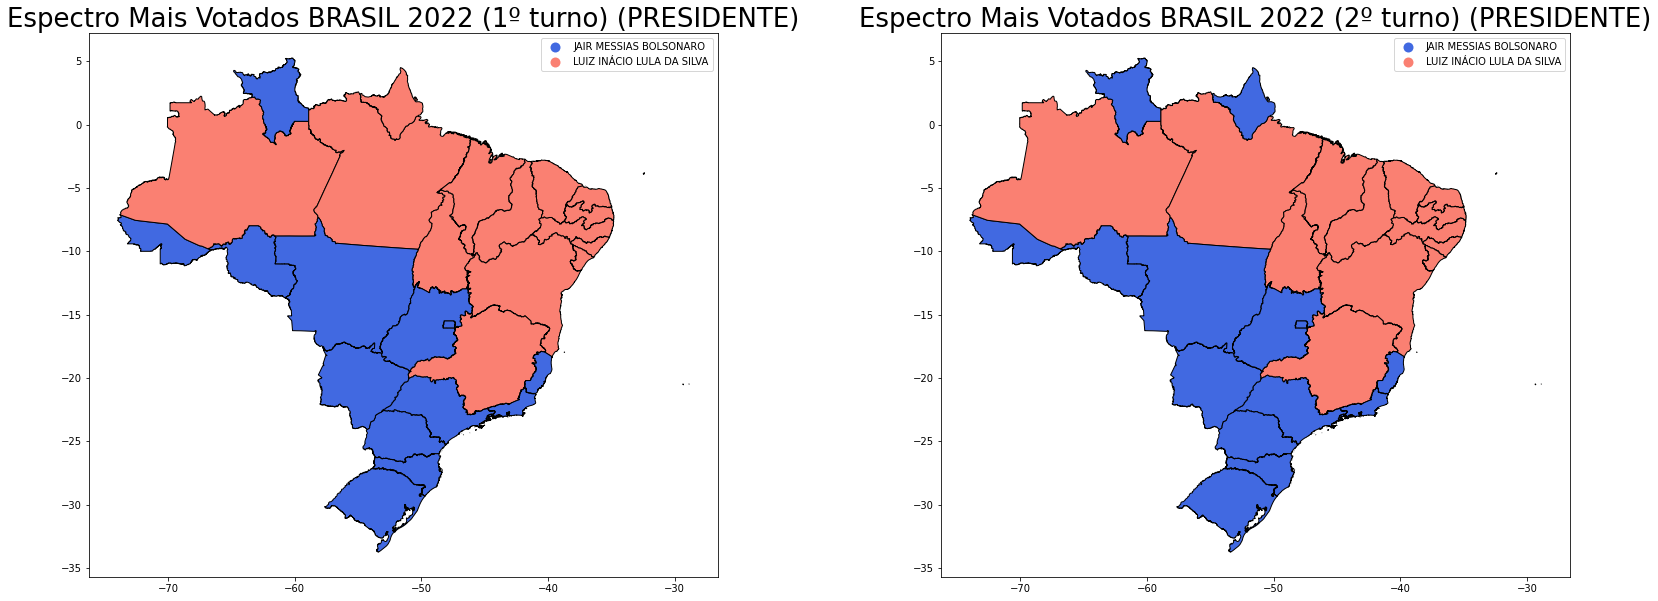

In [47]:
fig, ax = plt.subplots(1,2,figsize=(28,10))
ax[0].set_title(f'Espectro Mais Votados {LOCAL} 2022 (1º turno) ({TIPO_CANDIDATO})', color='black', size=26)
ax[1].set_title(f'Espectro Mais Votados {LOCAL} 2022 (2º turno) ({TIPO_CANDIDATO})', color='black', size=26)

candidatos_mais_votados_2022_1turno_UF_geo_df.plot(column='NM_VOTAVEL', legend=True,edgecolor="black", cmap=cmap, ax=ax[0])
candidatos_mais_votados_2022_2turno_UF_geo_df.plot(column='NM_VOTAVEL', legend=True,edgecolor="black", cmap=cmap, ax=ax[1]);


1º turno: <br>O candidato Bolsonaro venceu em 12 estados + Distrito Federal <br>
O candidato Lula venceu em 14 estados

2ºturno: <br>O candidato Bolsonaro venceu em 13 estados + Distrito Federal <br>
O candidato Lula venceu em 13 estados


Ps. Historicamente o candidato que vence nos estados do amazonas e minas gerais é o candidato eleito. Neste ano esse fato foi comprovado novamente.

## 5.2. Municipal

In [48]:
candidatos_mais_votados_2022_1turno_geo_df = geo_df.merge(candidatos_mais_votados_2022, left_on='name_muni', right_on='NM_MUNICIPIO')
candidatos_mais_votados_2022_2turno_geo_df = geo_df.merge(candidatos_mais_votados_2022_2_turno, left_on='name_muni', right_on='NM_MUNICIPIO')

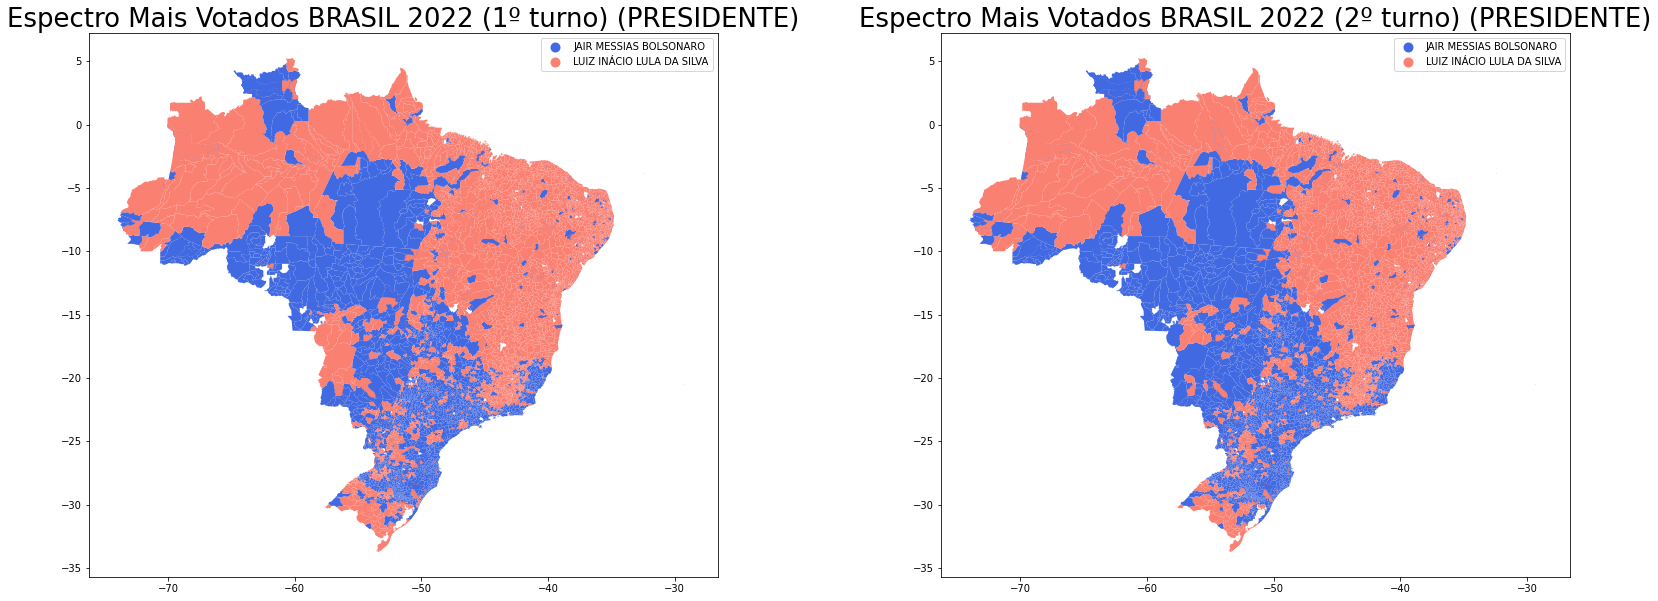

In [49]:
fig, ax = plt.subplots(1,2,figsize=(28,10))

ax[0].set_title(f'Espectro Mais Votados {LOCAL} 2022 (1º turno) ({TIPO_CANDIDATO})', color='black', size=26)
ax[1].set_title(f'Espectro Mais Votados {LOCAL} 2022 (2º turno) ({TIPO_CANDIDATO})', color='black', size=26)

candidatos_mais_votados_2022_1turno_geo_df.plot(column='NM_VOTAVEL', legend=True, cmap=cmap, ax=ax[0])
candidatos_mais_votados_2022_2turno_geo_df.plot(column='NM_VOTAVEL', legend=True, cmap=cmap, ax=ax[1]);


##5.3. Regiões


In [50]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [51]:
req = requests.get('https://www.estadosecapitaisdobrasil.com/')
if req.status_code == 200:
    print('Requisição bem sucedida!')
    content = req.content

Requisição bem sucedida!


In [52]:
soup = BeautifulSoup(content, 'html.parser')
table = soup.find(name='table')

In [53]:
!pip install html-table-parser-python3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
# https://www.geeksforgeeks.org/scrape-tables-from-any-website-using-python/
import urllib.request
from pprint import pprint
from html_table_parser.parser import HTMLTableParser
import pandas as pd

def url_get_contents(url):
    req = urllib.request.Request(url=url)
    f = urllib.request.urlopen(req)
    return f.read()

xhtml = url_get_contents('https://www.estadosecapitaisdobrasil.com/').decode('utf-8')
p = HTMLTableParser()
p.feed(xhtml)

regioes=pd.DataFrame(p.tables[0])
regioes.columns = regioes.loc[0]
regioes = regioes.drop(0)
regioes=regioes.drop( columns='Bandeira')
regioes['Região'] = regioes['Região'].apply(lambda x: x.replace('Centro-Oeste','Centro Oeste'))
regioes = regioes.rename(columns={"Sigla": "SG_UF"})
print(regioes.head())

0    Estado SG_UF     Capital    Região
1      Acre    AC  Rio Branco     Norte
2   Alagoas    AL      Maceió  Nordeste
3     Amapá    AP      Macapá     Norte
4  Amazonas    AM      Manaus     Norte
5     Bahia    BA    Salvador  Nordeste


In [55]:
regioes

,Estado,SG_UF,Capital,Região
1,Acre,AC,Rio Branco,Norte
2,Alagoas,AL,Maceió,Nordeste
3,Amapá,AP,Macapá,Norte
4,Amazonas,AM,Manaus,Norte
5,Bahia,BA,Salvador,Nordeste
6,Ceará,CE,Fortaleza,Nordeste
7,Distrito Federal,DF,Brasília,Centro Oeste
8,Espírito Santo,ES,Vitória,Sudeste
9,Goiás,GO,Goiânia,Centro Oeste
10,Maranhão,MA,São Luís,Nordeste


In [56]:
espec_type = pd.CategoricalDtype(categories=['Norte', 'Nordeste', 'Centro Oeste', 'Sudeste', 'Sul'], ordered=True)
regioes['Região'] = regioes['Região'].astype(espec_type)

In [57]:
regioes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 1 to 27
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Estado   27 non-null     object  
 1   SG_UF    27 non-null     object  
 2   Capital  27 non-null     object  
 3   Região   27 non-null     category
dtypes: category(1), object(3)
memory usage: 1.1+ KB


In [58]:
# candidatos_mais_votados_2022_1turno_regiao=candidatos_mais_votados_2022_1turno_UF.copy()
candidatos_mais_votados_2022_1turno_regiao=df_2022_1turno_por_estado.copy()
candidatos_mais_votados_2022_2turno_regiao=df_2022_2turno_por_estado.copy()


In [59]:
candidatos_mais_votados_2022_2turno_regiao

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,...,NR_SECAO,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
3523,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,270,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,175,1198,280001607829,ESCOLA DE 1 GRAU MARIA GUIOMAR BASTOS CAVALCANTE,"RUA TOPAZIO, 331, VELHO TIMBO"
3524,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,535,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,67,1813,280001607829,CENTRO DE ENSINO EM PERÍODO INTEGRAL CULTURA E...,"RUA LEPOLDINO DE AZEVEDO, QD. A-13"
3525,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,205,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,95,1198,280001607829,EM. PROFª JACIRA DE CARVALHO DA SILVA,"RUA NOVA YORK, 916"
3526,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,226,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,94,1252,280001607829,EE. NELLO LORENZON,"RUA SÃO GONÇALO DO SAPUCAÍ, 61"
3527,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,261,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,102,1279,280001607829,E M E F GAL EUCLYDES DE OLIVEIRA FIGUEIREDO,"RUA MARECHAL OLÍMPIO MOURÃO FILHO, 187"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5369745,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,71,1,PRESIDENTE,96,VOTO NULO,13,1058,-1,EMEF RAUL VIEIRA LUZ,"R ALIPIO BASTOS, 482"
5369746,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,122,1,PRESIDENTE,96,VOTO NULO,6,1228,-1,SINDICATO DOS TRABALHADORES RURAIS,AV. JOSE TAPETY S/N
5369747,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,248,1,PRESIDENTE,96,VOTO NULO,6,1490,-1,ESCOLA ESTADUAL WELDER DE ABREU SALES,"RUA LIBANO, S/N"
5369748,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,2,545,ELEIÇÃO GERAL FEDERAL 2022,30/10/2022,F,...,196,1,PRESIDENTE,96,VOTO NULO,14,1031,-1,"PEDRO DINIZ GONÇALVES, ESCOLA ESTADUAL",RUA SENADOR WALTER FRANCO


In [60]:
candidatos_mais_votados_2022_1turno_regiao = candidatos_mais_votados_2022_1turno_regiao.\
merge(regioes[['SG_UF','Região']], left_on='SG_UF', right_on='SG_UF')

candidatos_mais_votados_2022_2turno_regiao = candidatos_mais_votados_2022_2turno_regiao.\
merge(regioes[['SG_UF','Região']], left_on='SG_UF', right_on='SG_UF')

In [61]:
candidatos_mais_votados_2022_1turno_regiao.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,DT_ELEICAO,TP_ABRANGENCIA,...,CD_CARGO,DS_CARGO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,NR_LOCAL_VOTACAO,SQ_CANDIDATO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO,Região
0,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,138,1015,280001607829,CENTRO ADMINISTRATIVO FABIANO MELO (ANTIGA FAC...,"AV. GOIÁS, 556",Centro Oeste
1,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,108,1376,280001607829,E.M. BARRA DO ITÁ - POLO,RODOVIA BELA VISTA - PONTA PORÃ KM 40,Centro Oeste
2,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,86,1740,280001607829,EM CARLOS VILHALVA CRISTALDO,"RUA PÁDUA GAZAL, 13",Centro Oeste
3,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,96,1252,280001607829,EE DEPUTADO FERNANDO C. C.SALDANHA,"R. JORGE PEREIRA DOS SANTOS, 321",Centro Oeste
4,01/11/2022,16:05:25,2022,2,ELEIÇÃO ORDINÁRIA,1,544,ELEIÇÃO GERAL FEDERAL 2022,02/10/2022,F,...,1,PRESIDENTE,13,LUIZ INÁCIO LULA DA SILVA,81,1341,280001607829,EE ANTÔNIA DA SILVEIRA CAPILÉ,"R. ITAMARATI, 200",Centro Oeste


In [62]:
total_votos_por_Regiao_1_turno = candidatos_mais_votados_2022_1turno_regiao[candidatos_mais_votados_2022_1turno_regiao['NR_TURNO']== 1]\
.groupby(['Região','NR_VOTAVEL'])\
.agg({'NR_TURNO' :'first', 
      'Região':'first', 'NR_TURNO':'first', 'NR_VOTAVEL':"first", 'NM_VOTAVEL':"first",
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['Região'],keep='first')


total_votos_por_Regiao_2_turno = candidatos_mais_votados_2022_2turno_regiao[candidatos_mais_votados_2022_2turno_regiao['NR_TURNO']== 2]\
.groupby(['Região','NR_VOTAVEL'])\
.agg({'NR_TURNO' :'first', 
      'Região':'first', 'NR_TURNO':'first', 'NR_VOTAVEL':"first", 'NM_VOTAVEL':"first",
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)\
      .drop_duplicates(subset=['Região'],keep='first')

In [63]:
total_votos_por_Regiao_1_turno 

,,NR_TURNO,Região,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS
Região,NR_VOTAVEL,,,,,
Sudeste,22,1,Sudeste,22,JAIR MESSIAS BOLSONARO,23470529
Nordeste,13,1,Nordeste,13,LUIZ INÁCIO LULA DA SILVA,21753139
Sul,22,1,Sul,22,JAIR MESSIAS BOLSONARO,9568041
Centro Oeste,22,1,Centro Oeste,22,JAIR MESSIAS BOLSONARO,4727672
Norte,13,1,Norte,13,LUIZ INÁCIO LULA DA SILVA,4554630


In [64]:
geo_Regiao

,code_region,name_region,geometry
0,1.0,Norte,"MULTIPOLYGON (((-46.43676 -1.01905, -46.43723 ..."
1,2.0,Nordeste,"MULTIPOLYGON (((-38.94622 -13.38645, -38.94767..."
2,3.0,Sudeste,"MULTIPOLYGON (((-48.03716 -25.35794, -48.03822..."
3,4.0,Sul,"MULTIPOLYGON (((-52.10249 -31.79121, -52.10147..."
4,5.0,Centro Oeste,"MULTIPOLYGON (((-57.83371 -20.93628, -57.84443..."


In [65]:
total_votos_por_Regiao_1_turno.reset_index(drop = True, inplace = True)
total_votos_por_Regiao_2_turno.reset_index(drop = True, inplace = True)

In [66]:
mapa_mais_votados_2022_1turno_geo_regiao = geo_Regiao.merge(total_votos_por_Regiao_1_turno, left_on='name_region', right_on='Região')
mapa_mais_votados_2022_2turno_geo_regiao = geo_Regiao.merge(total_votos_por_Regiao_2_turno, left_on='name_region', right_on='Região')

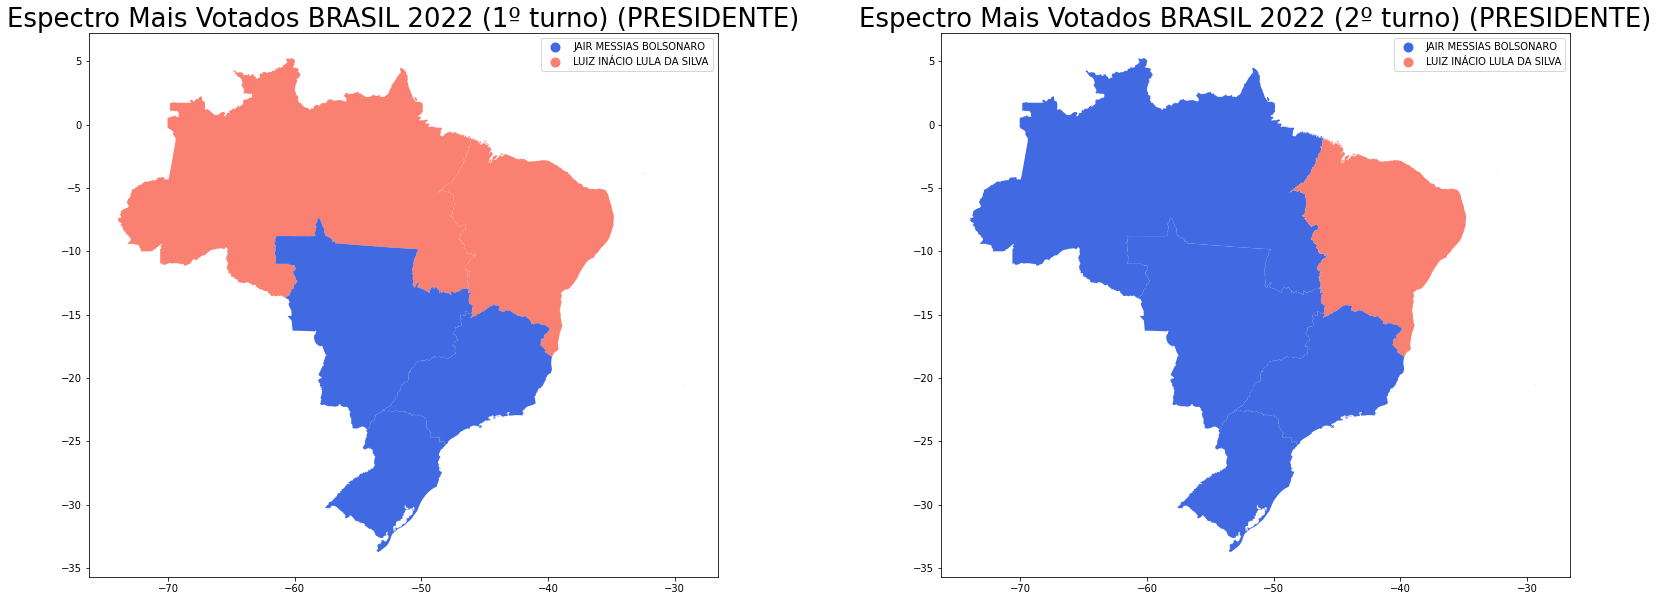

In [67]:
fig, ax = plt.subplots(1,2,figsize=(28,10))

ax[0].set_title(f'Espectro Mais Votados {LOCAL} 2022 (1º turno) ({TIPO_CANDIDATO})', color='black', size=26)
ax[1].set_title(f'Espectro Mais Votados {LOCAL} 2022 (2º turno) ({TIPO_CANDIDATO})', color='black', size=26)

mapa_mais_votados_2022_1turno_geo_regiao.plot(column='NM_VOTAVEL', legend=True, cmap=cmap, ax=ax[0])
mapa_mais_votados_2022_2turno_geo_regiao.plot(column='NM_VOTAVEL', legend=True, cmap=cmap, ax=ax[1]);

Quando se separa os dados por região, conseguimos perceber que o candidato jair bolsonaro venceu em 3 regiões no 1 turno e 4 regiões no segundo turno.

-----------------


#6. Votação dos dois primeiros candidatos a presidencia 2022

In [68]:
df_2022_1turno_por_candidato =df2.query('NR_TURNO == 1')
df_2022_2turno_por_candidato =df2.query('NR_TURNO == 2')

Total_votos_candidatos_2022_1turno = df_2022_1turno_por_candidato[df_2022_1turno_por_candidato['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','NM_VOTAVEL'])\
.agg({'NR_TURNO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)
Total_votos_candidatos_2022_1turno = Total_votos_candidatos_2022_1turno.query('NR_VOTAVEL == 13 | NR_VOTAVEL == 22')


Total_votos_candidatos_2022_2turno = df_2022_2turno_por_candidato[df_2022_2turno_por_candidato['DS_CARGO']== TIPO_CANDIDATO]\
.groupby(['NR_VOTAVEL','NM_VOTAVEL'])\
.agg({'NR_TURNO':'first',
      'QT_VOTOS' : 'sum' })\
      .sort_values(by='QT_VOTOS',ascending=False)

Total_votos_candidatos_2022_2turno = Total_votos_candidatos_2022_2turno.query('NR_VOTAVEL == 13 | NR_VOTAVEL == 22')
Total_votos_candidatos_2022_1turno.reset_index(drop = False, inplace = True)
Total_votos_candidatos_2022_2turno.reset_index(drop = False, inplace = True)
Total_votos_candidatos_por_turno_2022 = pd.concat([Total_votos_candidatos_2022_1turno, Total_votos_candidatos_2022_2turno])
Total_votos_candidatos_por_turno_2022.reset_index(drop = True, inplace = True)



In [69]:
Total_votos_candidatos_2022_1turno

,NR_VOTAVEL,NM_VOTAVEL,NR_TURNO,QT_VOTOS
0,13,LUIZ INÁCIO LULA DA SILVA,1,57259504
1,22,JAIR MESSIAS BOLSONARO,1,51072345


In [70]:
fig = px.histogram(Total_votos_candidatos_por_turno_2022, x="NM_VOTAVEL", y="QT_VOTOS",
             color='NR_TURNO', barmode='group', text_auto='.5s',title="Votação dos dois primeiros candidatos a presidencia 2022",
             height=400)
fig.show()

# 7. Conclusão

Apesar de Jair Messias Bolsonaro ter vencido em mais cidades, estados e regiões ele não conseguiu se reeleger, visto que, Lula abriu uma grande vantagem nas pequenas cidades, conseguindo uma vantagem de 6,2 Milhões de votos, nas cidades médias o atual Presidente Jair Bolsonaro, abriu vantagem de apenas 4,1 milões de votos, nas grandes metropoles, os candidatos ficaram poraticamente empatados, porém lula abriu uma vantagem de 114 mil votos.
<br>
Fonte: https://g1.globo.com/politica/eleicoes/2022/eleicao-em-numeros/noticia/2022/11/04/lula-abriu-vantagem-de-62-milhoes-de-votos-nos-pequenos-municipios-bolsonaro-de-41-milhao-nas-cidades-medias.ghtml

Sendo assim, o candidato Luiz Inácio Lula da Silva, conseguiu se eleger pela 3º vez na história, iniciando seu mandato de 4 anos, em janeiro de 2023.